This code does the following:
- Trains RFCML model on manual labels
- Predicts fight labels for new dataset
- Plots ethogram and annotated video

To install the environment:

conda env create -f environment.yml
conda activate QuantBio_env

Files required:
- Ground truth labels, respective videos, trajectories
- New dataset with respective trajectories, raw video

- Code made to adapt a folder structure: ground_truth_root--gt1
                                                            --gt1.mp4
                                                            --gt1_trajectories.csv
                                                            --gt1_manual_labels.csv
                                                          --gt2
                                                            --gt2.mp4 etc.

In [12]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score, 
    recall_score,
    f1_score,
    precision_recall_curve,
    roc_curve
)
from sklearn.model_selection import train_test_split
from collections import deque
import cv2
import glob
import QuantBio_functions as functions
import importlib
importlib.reload(functions)
%matplotlib inline

Combine ground truth labels from online annotator, convert to frames

In [ ]:
#change paths to respective ground truth files, video file and output path

functions.generate_final_label_file(
    annotator_csvs=[
        "gt1_annotatorA.csv",   
        "gt1_annotatorB.csv",
        "gt1_annotatorC.csv"
    ],
    video_path="gt1.mp4",
    output_path="gt1_final_labels.csv",
    fps=60,
    method="majority"
)


Load manually annotated CSV and combine with respective trajectories

In [ ]:
#if files are saved on a root folder, with each folder (gt1,gt2,gt3) having the manual labels and respective trajectories

gt_root = "path to root folder containing gt folders (gt1,gt2,gt3)"

gt_folders = sorted([
    os.path.join(gt_root, d)
    for d in os.listdir(gt_root)
    if os.path.isdir(os.path.join(gt_root, d))
])

temporal_csvs = []

for folder in gt_folders:
    out_csv = functions.process_dataset_folder(folder)
    temporal_csvs.append(out_csv)


Trajectory: /Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/ground_truth/gt1/trajectories.csv
Labels: /Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/ground_truth/gt1/manual_labeled_fights.csv
Saved: /Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/ground_truth/gt1/temporal_features_with_labels.csv
Trajectory: /Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/ground_truth/gt2/trajectories.csv
Labels: /Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/ground_truth/gt2/manual_labeled_fights.csv
Saved: /Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/ground_truth/gt2/temporal_features_with_labels.csv
Trajectory: /Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/ground_truth/gt3/trajectories.csv
Labels: /Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/ground_truth

Train RFCML

In [ ]:
#saves the temporal features within each folder

GT_ROOT = "path tor root folder"

temporal_csvs = sorted(
    glob.glob(os.path.join(GT_ROOT, "*/temporal_features_with_labels.csv"))
)

print("Found GT videos:", len(temporal_csvs))
for p in temporal_csvs:
    print(p)

Found GT videos: 3
/Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/ground_truth/gt1/temporal_features_with_labels.csv
/Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/ground_truth/gt2/temporal_features_with_labels.csv
/Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/ground_truth/gt3/temporal_features_with_labels.csv


In [ ]:
#split test and train data

np.random.seed(42)

all_indices = np.arange(len(temporal_csvs))
test_idx = np.random.choice(all_indices, size=1, replace=False)
train_idx = np.setdiff1d(all_indices, test_idx)

print("Train indices:", train_idx)
print("Test index:", test_idx)


Train indices: [1 2]
Test index: [0]


In [5]:
train_dfs = []
test_dfs = []

for i, path in enumerate(temporal_csvs):
    df = pd.read_csv(path)

    if i in train_idx:
        train_dfs.append(df)
    else:
        test_dfs.append(df)

train_df = pd.concat(train_dfs, ignore_index=True)
test_df  = pd.concat(test_dfs, ignore_index=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (39522, 37)
Test shape: (21561, 37)


In [6]:
X_train = train_df.drop(columns=["frame", "label"])
y_train = train_df["label"]

X_test  = test_df.drop(columns=["frame", "label"])
y_test  = test_df["label"]


In [7]:
clf = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)


,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
threshold=0.4

y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

y_pred_adj = (y_probs >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_adj)
TN, FP, FN, TP = cm.ravel()

FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

print("\n=== THRESHOLDED RESULTS ===")
print(cm)
print(classification_report(y_test, y_pred_adj))

print(f"False Positive Rate: {FPR*100:.2f}%")
print(f"False Negative Rate: {FNR*100:.2f}%")



Confusion Matrix:
[[14490   702]
 [ 2562  3807]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     15192
           1       0.84      0.60      0.70      6369

    accuracy                           0.85     21561
   macro avg       0.85      0.78      0.80     21561
weighted avg       0.85      0.85      0.84     21561


=== THRESHOLDED RESULTS ===
[[13652  1540]
 [ 1625  4744]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     15192
           1       0.75      0.74      0.75      6369

    accuracy                           0.85     21561
   macro avg       0.82      0.82      0.82     21561
weighted avg       0.85      0.85      0.85     21561

False Positive Rate: 10.14%
False Negative Rate: 25.51%


In [ ]:
#save the RFCML model

model_save_path= "path to save model"
joblib.dump(
    (clf, X_train.columns.tolist(), threshold),
    model_save_path
)

['/Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/rfcml_model.pkl']

Predict fights in a new dataset

In [ ]:
#get the temporal features for new dataset

functions.process_dataset_folder(
    folder_path="path to new dataset folder with video and trajectory files",
    fps=60,
    window_size=40
)


Trajectory: /Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/new_dataset/trajectories.csv
No label file found — running in prediction mode.
Saved: /Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/new_dataset/temporal_features.csv


'/Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/new_dataset/temporal_features.csv'

In [ ]:
model_path = "path to rfcml model"

clf, expected_features, threshold = joblib.load(model_path)

print("Model loaded.")
print("Threshold:", threshold)

temporal_csv = "output path to new dataset temporal features CSV"

df_new = pd.read_csv(temporal_csv)

if "frame" not in df_new.columns:
    raise ValueError("Temporal CSV must contain 'frame' column.")


missing = set(expected_features) - set(df_new.columns)
if missing:
    raise ValueError(f"Missing expected features: {missing}")


X_new = df_new[expected_features]


probs = clf.predict_proba(X_new)[:, 1]

preds = (probs >= threshold).astype(int)


df_new["fight_probability"] = probs
df_new["predicted_label"] = preds

output_path = temporal_csv.replace(".csv", "_predictions.csv")

df_new.to_csv(output_path, index=False)

print("Predictions saved to:")
print(output_path)


Model loaded.
Threshold: 0.4
Predictions saved to:
/Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/new_dataset/temporal_features_predictions.csv


Visualizations

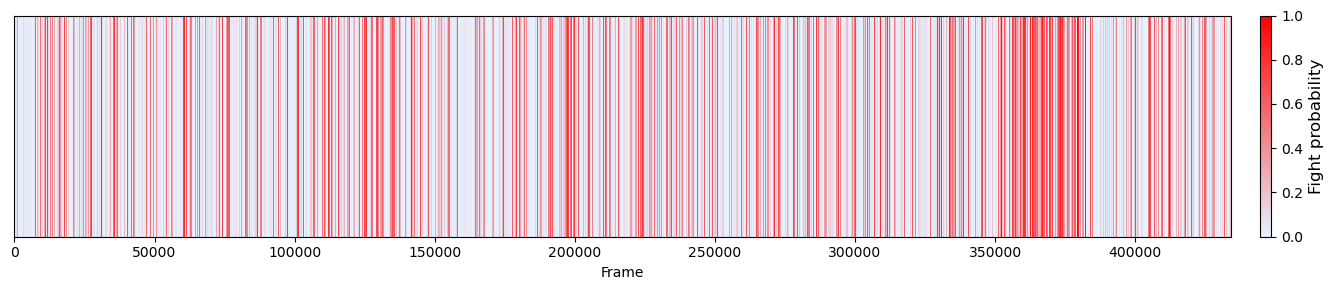

In [ ]:
pred_path = "path to predictions CSV file for new dataset"

df = pd.read_csv(pred_path)

fight_prob = df["fight_probability"].to_numpy()
prob_2d = fight_prob[np.newaxis, :]  

cmap = LinearSegmentedColormap.from_list(
    "lightblue_red",
    ["#e6f2ff", "red"]   
)

fig, ax = plt.subplots(figsize=(15, 3)) 

im = ax.imshow(
    prob_2d,
    aspect="auto",
    cmap=cmap,
    vmin=0,
    vmax=1,
    interpolation="nearest"  
)

ax.set_yticks([])
ax.set_xlabel("Frame")

cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("Fight probability", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
functions.annotate_most_fight_chunk(
    video_path="path to new dataset video file",
    trajectory_csv="path to new dataset trajectories CSV",
    predictions_csv="path to new dataset predictions CSV",
    output_path="path to output annotated video file",
    window_minutes=5,
    threshold=0.4,
    trail_length=10)



Trajectory columns: ['time', 'x1', 'y1', 'x2', 'y2']
Prediction columns: ['inter_animal_distance_mean', 'inter_animal_distance_std', 'inter_animal_distance_max', 'inter_animal_distance_min', 'inter_animal_distance_delta', 'speed1_mean', 'speed1_std', 'speed1_max', 'speed1_min', 'speed1_delta', 'speed2_mean', 'speed2_std', 'speed2_max', 'speed2_min', 'speed2_delta', 'acc1_mean', 'acc1_std', 'acc1_max', 'acc1_min', 'acc1_delta', 'acc2_mean', 'acc2_std', 'acc2_max', 'acc2_min', 'acc2_delta', 'heading1_mean', 'heading1_std', 'heading1_max', 'heading1_min', 'heading1_delta', 'heading2_mean', 'heading2_std', 'heading2_max', 'heading2_min', 'heading2_delta', 'frame', 'fight_probability', 'predicted_label']
Converting trajectory time → frame (fps=60)
FPS: 60.0
Window size (frames): 18000
Most fight-dense window:
Start frame: 362428
End frame: 380428
Starting annotation...
Annotated chunk saved to: /Volumes/jlarsch/default/D2c/Deeksha/Aggression_assay/analyses/quant_bio_2026/new_dataset/annotat